In [1]:
from exp.utils import *
from exp.models import *
from exp.losses import *
from fastai.vision.all import *

In [23]:
lr = 1e-2
bs = 32
epochs = 10
device = get_device()

Using the GPU!


In [3]:
p_data = get_data_path()
p_train_valid = p_data/"train_valid_images"
p_train_images = p_train_valid/"train_images"
p_valid_images = p_train_valid/"valid_images"
p_test_images  = p_data/"test_images"
p_dev_images = p_data/"dev_images"

In [4]:
# Load data
label = "Cardiomegaly"
train_df, valid_df, test_df = get_dataframes(include_labels=get_labels(), 
                                             small=False)
#print(train_df.shape, valid_df.shape, test_df.shape)
train_df = get_binary_df(label, train_df)
valid_df = get_binary_df(label, valid_df)
test_df  = get_binary_df(label, test_df)

complete_df = pd.concat([train_df, valid_df, test_df])
complete_df = complete_df.drop(columns=["Follow-up #", "Patient ID", "Patient Age", "Patient Gender", 
                   "View Position", "OriginalImage[Width", "Height]", 
                   "OriginalImagePixelSpacing[x", "y]", "No Finding"])

In [5]:
def label_func(fname):
    lbl = complete_df[complete_df["Image Index"] == fname.name]["Cardiomegaly"].values[0]
    return "C" if lbl > 0 else "No C"

def splitter_func(fn):
    return fn.parent.stem == "valid_images" 

In [6]:
train_label = train_df[[label]].values
neg_weights, pos_weights = compute_class_freqs(train_label)
neg_weights, pos_weights = torch.Tensor(neg_weights), torch.Tensor(pos_weights)
print(neg_weights, pos_weights)

tensor([0.0203]) tensor([0.9797])


In [7]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))

dsets = dblock.datasets(p_dev_images)

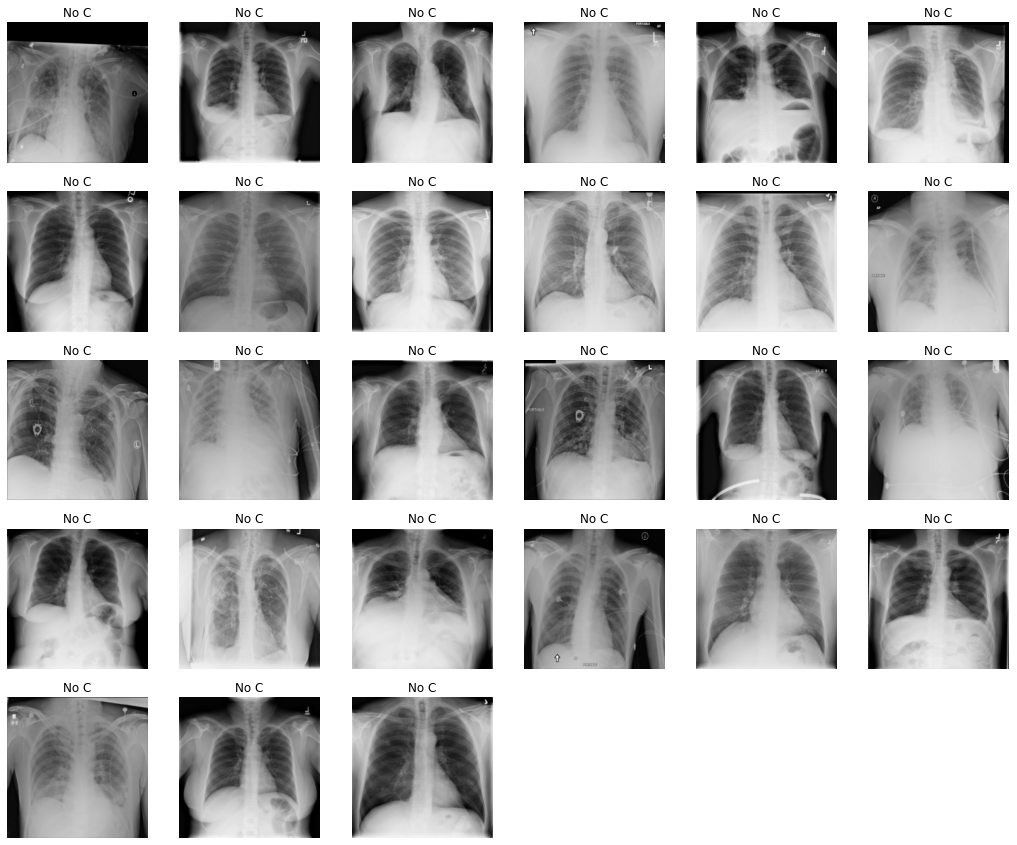

In [9]:
dls = dblock.dataloaders(p_train_valid, bs=bs)
dls.show_batch(max_n=27)

In [ ]:
#dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
#                   get_items = get_image_files,
#                   get_y     = label_func,
#                   splitter  = FuncSplitter(splitter_func),
#                   item_tfms = Resize(224))

#dsets = dblock.datasets(p_train_valid)

In [ ]:
#dls = dblock.dataloaders(p_train_valid, bs=bs)
#dls.show_batch(max_n=27)

In [10]:
dsets.vocab

['C', 'No C']

In [24]:
weights = torch.Tensor([neg_weights, pos_weights]).to(device)
loss_function = CrossEntropyLossFlat(weight=weights)

In [25]:
learn = cnn_learner(dls, resnet18, lr=1e-2, loss_func=loss_function, 
                    metrics=[accuracy, RocAucBinary()])

In [ ]:
learn.summary()

In [26]:
learn.fit_one_cycle(epochs, lr_max=lr)

KeyboardInterrupt: 

In [ ]:
learn.save("resnet18_v2", with_opt=True)

In [ ]:
class WeightedLoss

In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7, reduced=True):
    def weighted_loss(y_pred, y_true):
        loss = 0.0
        for i in range(len(pos_weights)):
            if reduced:
                loss_pos = torch.mean(-pos_weights[i] * y_true[:, i] * torch.log(y_pred[:, i] + epsilon))
                loss_neg = torch.mean(-neg_weights[i] * (1 - y_true[:, i]) * torch.log(1 - y_pred[:, i] + epsilon))
            else:
                loss_pos = -pos_weights[i] * y_true[:, i] * torch.log(y_pred[:, i] + epsilon)
                loss_neg = -neg_weights[i] * (1 - y_true[:, i]) * torch.log(1 - y_pred[:, i] + epsilon)
            loss += loss_pos + loss_neg
        return loss
    return weighted_loss

In [ ]:
class BaseLoss():
    "Same as `loss_cls`, but flattens input and target."
    activation=decodes=noops
    def __init__(self, loss_cls, *args, axis=-1, flatten=True, floatify=False, is_2d=True, **kwargs):
        store_attr("axis,flatten,floatify,is_2d")
        self.func = loss_cls(*args,**kwargs)
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"FlattenedLoss of {self.func}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v

    def _contiguous(self,x):
        return TensorBase(x.transpose(self.axis,-1).contiguous()) if isinstance(x,torch.Tensor) else x

    def __call__(self, inp, targ, **kwargs):
        inp,targ  = map(self._contiguous, (inp,targ))
        if self.floatify and targ.dtype!=torch.float16: targ = targ.float()
        if targ.dtype in [torch.int8, torch.int16, torch.int32]: targ = targ.long()
        if self.flatten: inp = inp.view(-1,inp.shape[-1]) if self.is_2d else inp.view(-1)
        return self.func.__call__(inp, targ.view(-1) if self.flatten else targ, **kwargs)

In [ ]:
#learn.lr_find()

In [ ]:
learn.save("untrained_resnet18", with_opt=True)

In [ ]:
learn.fit_one_cycle(epochs, lr_max=lr)

In [ ]:
learn.fine_tune(3)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()

In [ ]:
interp.plot_top_losses(9)